the second sequence of images recorded in the another environnement of the calibration images.

- image recorded: `scene.hdf5`
- calibration recored in different environment: `calibration_set_2.hdf5`

We continue using Linear Regression as a method to find the `gain` and `offset`

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.linear_model import LinearRegression

# 2A. Load Data

In [2]:
dataset_location = "C:/Users/thang/OneDrive/Desktop/school/DataChallenge/dataset_for_students/"

In [7]:
scene_df = pd.read_hdf(dataset_location+'scene.hdf5')

calibration_df = pd.read_hdf(dataset_location +'calibration_set_2.hdf5')

In [4]:
def display(scene_df, corrected_scene_images,index=15):
    plt.figure(figsize=(15, 5))

    # Original scene image
    plt.subplot(1, 2, 1)
    plt.title("Original Scene Image")
    plt.imshow(scene_df['image'][index], cmap='gray')

    # Denoised scene image
    plt.subplot(1, 2, 2)
    plt.title("Denoised Scene Image")
    plt.imshow(corrected_scene_images[index], cmap='gray')

    plt.show()

# 2B. Approach

## 2.1 Different way of apply NUC image

1. overall image **(in notebook `challenge1.ipynb`)**
2. through columns
3. each pixels 

### 2.1.1 Uses linear regression on image

In [15]:
from sklearn.linear_model import LinearRegression

# Extract calibration images and their corresponding temperatures
calibration_images = np.stack(calibration_df['image'].values)
temperatures = calibration_df['t_fpa'].values  # Example: FPA temperature in degrees Celsius

# Get the dimensions of the images
num_images, height, width = calibration_images.shape

# Reshape the data for regression
pixels = calibration_images.reshape(num_images, -1).T  # Shape: (num_pixels, num_images)

# Initialize arrays for gain and offset
gain = np.zeros((height, width))
offset = np.zeros((height, width))

# Perform linear regression for each pixel
for i in range(pixels.shape[0]):
    y = pixels[i, :]
    X = temperatures.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    gain.flat[i] = reg.coef_[0]
    offset.flat[i] = reg.intercept_

# Reshape gain and offset back to image dimensions
gain = gain.reshape(height, width)
offset = offset.reshape(height, width)

In [18]:
# Function to apply gain and offset correction
def apply_nuc(image, gain, offset):
    return (image - offset) / gain

In [19]:
# Apply the correction to each scene image
scene_images = np.stack(scene_df['image'].values)
linear_reg_scene_images = np.array([apply_nuc(img, gain, offset) for img in scene_images])

C:\Users\thang\AppData\Local\Temp\ipykernel_17176\921519736.py:3: RuntimeWarning: invalid value encountered in divide
  return (image - offset) / gain


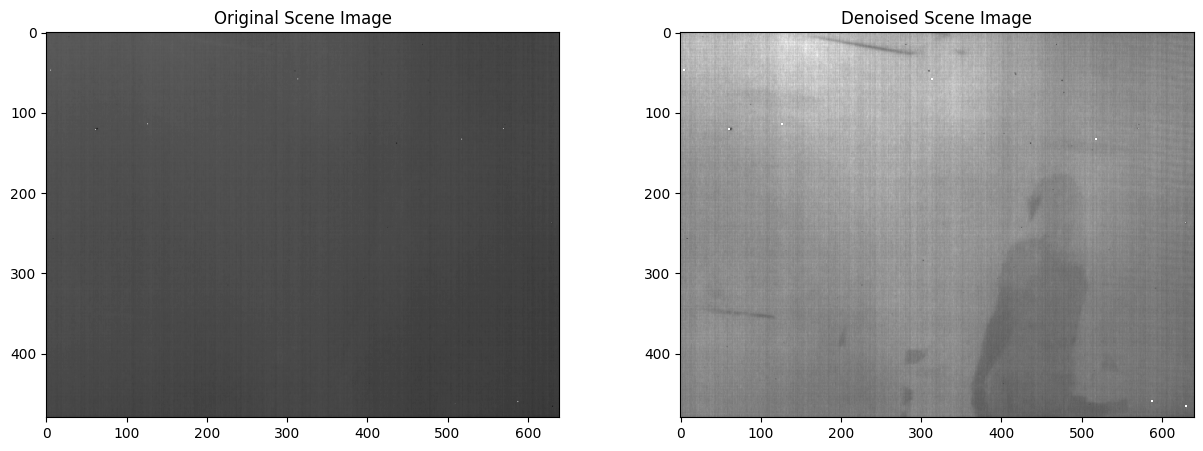

In [20]:
display(scene_df, linear_reg_scene_images,350)

### 2.1.2 Uses linear regression on columns

In [8]:
def estimate_parameters(calibration_df):

    calibration_images = calibration_df['image'].values
    calibration_temperatures = calibration_df['t_fpa'].values
    height, width = calibration_images[0].shape
    
    # Initialize arrays for offsets and responsivities for each column
    offsets = np.zeros(width)
    responsivities = np.zeros(width)
    
    # Perform linear regression for each column
    for col in range(width):
        # Extract the column data for all images
        column_data = np.array([img[:, col] for img in calibration_images])
        
        # Fit linear regression model for each column
        model = LinearRegression().fit(calibration_temperatures.reshape(-1, 1), column_data)
        offsets[col] = model.intercept_ if np.isscalar(model.intercept_) else model.intercept_[0]
        responsivities[col] = model.coef_[0] if np.isscalar(model.coef_[0]) else model.coef_[0][0]
    
    return offsets, responsivities

In [12]:
# Function to apply NUC with handling for division by zero
def apply_nuc(raw_image, offsets, responsivities):
    height, width = raw_image.shape
    corrected_image = np.zeros_like(raw_image)
    
    for col in range(width):
        corrected_image[:, col] = (raw_image[:, col] - offsets[col]) / responsivities[col]
    
    # Handle invalid values
    corrected_image[~np.isfinite(corrected_image)] = 0  # Set -inf, inf, NaN to 0
    return corrected_image

In [13]:
offsets, responsivities = estimate_parameters(calibration_df)

# Extract scene images
scene_images = np.stack(scene_df['image'].values)

# Apply the correction to each pixel of each scene image
corrected_scene_images = np.array([apply_nuc(img, offsets, responsivities) for img in scene_images])

C:\Users\thang\AppData\Local\Temp\ipykernel_17176\195036721.py:7: RuntimeWarning: divide by zero encountered in divide
  corrected_image[:, col] = (raw_image[:, col] - offsets[col]) / responsivities[col]
C:\Users\thang\AppData\Local\Temp\ipykernel_17176\195036721.py:7: RuntimeWarning: invalid value encountered in divide
  corrected_image[:, col] = (raw_image[:, col] - offsets[col]) / responsivities[col]


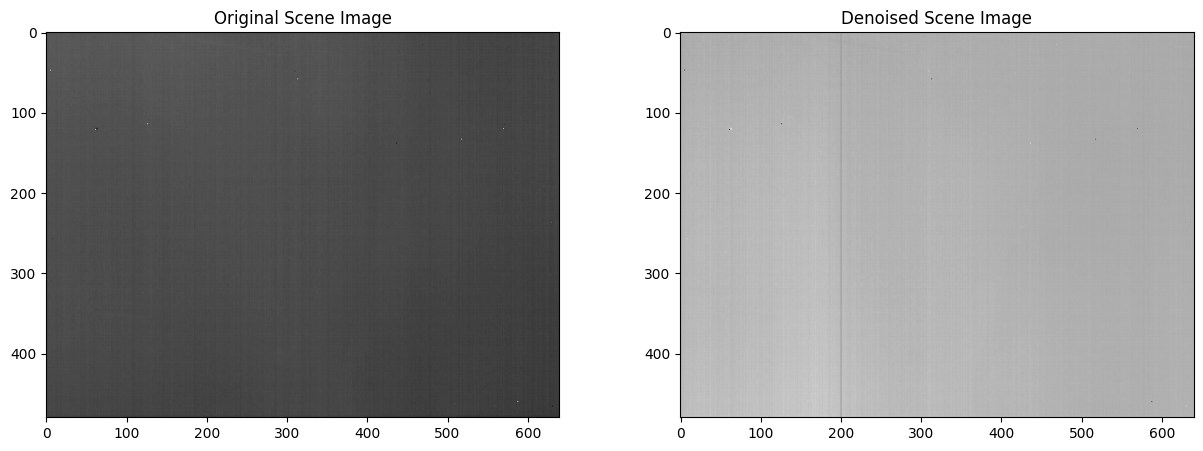

In [14]:
display(scene_df, corrected_scene_images,350)

### 2.1.3 Uses linear regression on pixels

In [21]:
# Function to estimate offset and responsivity
def estimate_parameters(calibration_df):
    calibration_images = calibration_df['image'].values
    calibration_temperatures = calibration_df['t_fpa'].values
    height, width = calibration_images[0].shape
    num_pixels = height * width
    
    # Reshape images for linear regression
    images_reshaped = np.array([img.ravel() for img in calibration_images])
    
    offsets = np.zeros(num_pixels)
    responsivities = np.zeros(num_pixels)
    
    for i in range(num_pixels):
        model = LinearRegression().fit(calibration_temperatures.reshape(-1, 1), images_reshaped[:, i])
        offsets[i] = model.intercept_
        responsivities[i] = model.coef_[0]
    
    # Reshape back to original image shape
    offsets = offsets.reshape(height, width)
    responsivities = responsivities.reshape(height, width)
    
    return offsets, responsivities

In [25]:
# Function to apply gain and offset correction
def apply_nuc(image, offset, gain):
    return (image - offset) / gain

In [26]:
offsets, responsivities = estimate_parameters(calibration_df)

# Extract scene images
scene_images = np.stack(scene_df['image'].values)

# Apply the correction to each pixel of each scene image
corrected_scene_images = np.array([apply_nuc(img, offsets, responsivities) for img in scene_images])

C:\Users\thang\AppData\Local\Temp\ipykernel_17176\3901089800.py:3: RuntimeWarning: invalid value encountered in divide
  return (image - offset) / gain


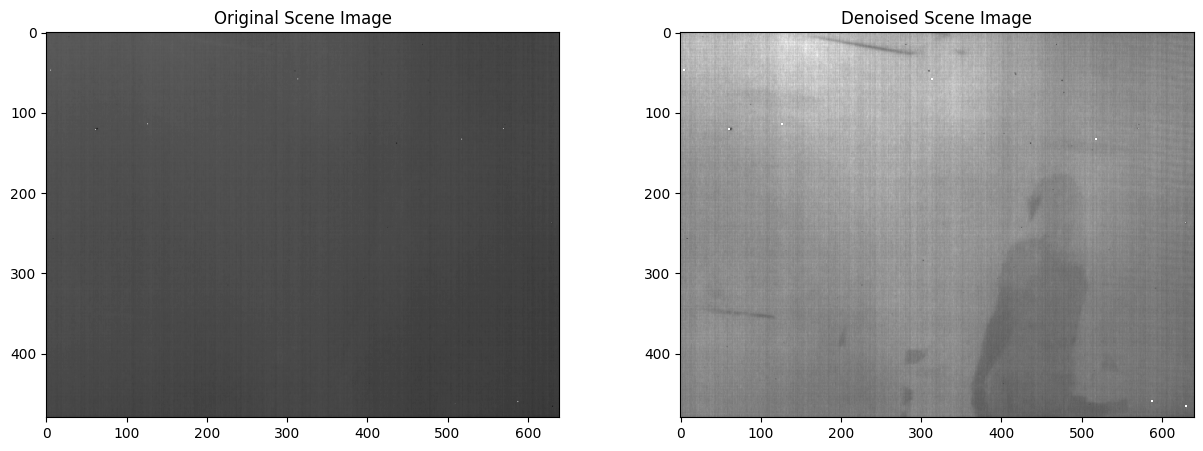

In [27]:
display(scene_df, corrected_scene_images,350)

## 2.2 With Black Body temperature

In [28]:
# Function to estimate offset and responsivity
def estimate_parameters(calibration_df):
    calibration_images = calibration_df['image'].values
    calibration_temperatures = np.vstack((calibration_df['t_fpa'].values, calibration_df['t_cn'].values)).T
    height, width = calibration_images[0].shape
    num_pixels = height * width
    
    # Reshape images for linear regression
    images_reshaped = np.array([img.ravel() for img in calibration_images])
    
    offsets = np.zeros(num_pixels)
    responsivities = np.zeros((num_pixels, calibration_temperatures.shape[1]))  # Adjust for multiple features
    
    for i in range(num_pixels):
        model = LinearRegression().fit(calibration_temperatures, images_reshaped[:, i])
        offsets[i] = model.intercept_
        responsivities[i, :] = model.coef_
    
    # Reshape back to original image shape
    offsets = offsets.reshape(height, width)
    responsivities = responsivities.reshape(height, width, -1)  # Adjust for multiple features
    
    return offsets, responsivities

In [29]:
# Function to apply the correction to each scene image
def apply_correction(scene_image, offsets, responsivities, scene_temp, avg_black_body_temp):
    height, width = scene_image.shape
    corrected_image = np.zeros_like(scene_image)
    
    for i in range(height):
        for j in range(width):
            intercept = offsets[i, j]
            coef_fpa = responsivities[i, j, 0]
            coef_cn = responsivities[i, j, 1]
            expected_value = intercept + coef_fpa * scene_temp + coef_cn * avg_black_body_temp
            corrected_image[i, j] = scene_image[i, j] - expected_value
    
    return corrected_image


In [30]:
offsets, responsivities = estimate_parameters(calibration_df)

# Extract scene images
scene_images = np.stack(scene_df['image'].values)

# Calculate the average black body temperature from calibration data
avg_black_body_temp = calibration_df['t_cn'].mean()

# Process each scene image
corrected_scene_images = []
for index, row in scene_df.iterrows():
    scene_image = row['image']
    scene_temp = row['t_fpa']
    corrected_image = apply_correction(scene_image, offsets, responsivities, scene_temp, avg_black_body_temp)
    corrected_scene_images.append(corrected_image)

# Convert corrected_scene_images to numpy array
corrected_scene_images = np.array(corrected_scene_images)

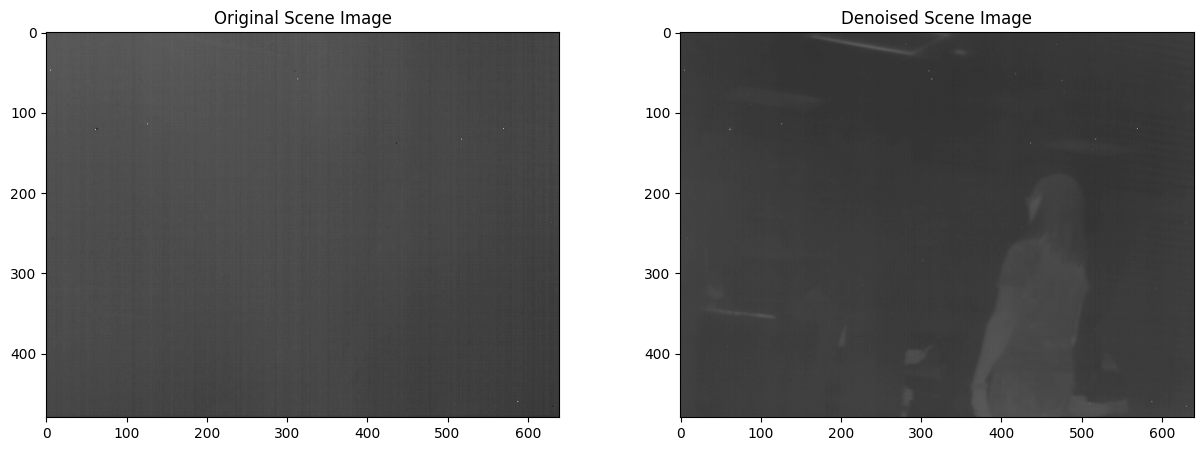

In [31]:
display(scene_df, corrected_scene_images,350)

## 2.3 Different denoise

In [32]:
from skimage import exposure, img_as_float
def plot_img_and_hist(image, axes, bins=256):
    """
    Plot an image along with its histogram (pdf) and cumulative histogram (cdf).
    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()
    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])
    return ax_img, ax_hist, ax_cdf

def hist_cdf_plot(img):
    fig, ax = plt.subplots(1, 2,figsize=(10, 3))
    fig.tight_layout()
    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, ax)

    ax_hist.set_title('hist + cdf')
    ax_cdf.set_ylabel('Fraction of total intensity')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

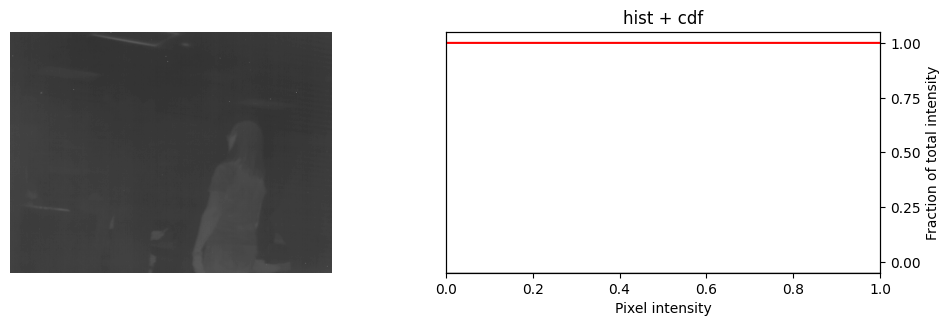

In [40]:
hist_cdf_plot(corrected_scene_images[350])

### 2.3.1 Histogram equalization

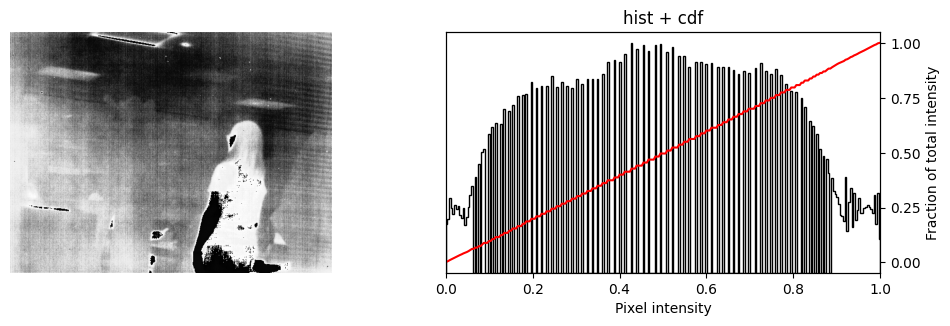

In [34]:
def histogram_equalization(image):
    # Apply histogram equalization
    equalized_image = cv2.equalizeHist(image.astype(np.uint8))
    return equalized_image

denoise_img = histogram_equalization(corrected_scene_images[350])

hist_cdf_plot(denoise_img)


### 2.3.2 CLAHE equalization

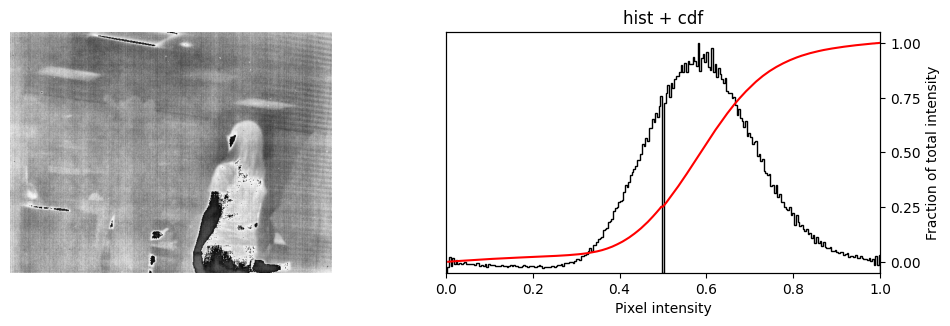

In [35]:
def clahe_equalization(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    # Create CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    # Apply CLAHE to the image
    clahe_image = clahe.apply(image.astype(np.uint8))
    return clahe_image


denoise_img = clahe_equalization(corrected_scene_images[350])

hist_cdf_plot(denoise_img)

### 2.3.3 Gaussian filter

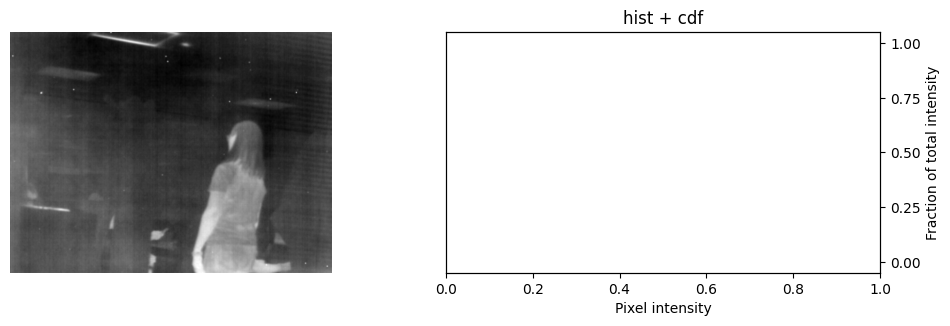

In [36]:
def gaussian_filter(image, kernel_size=5, sigma=1.0):
    # Apply Gaussian filter
    filtered_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    return filtered_image

denoise_img = gaussian_filter(corrected_scene_images[350])

hist_cdf_plot(denoise_img)

### 2.3.4 Median filter

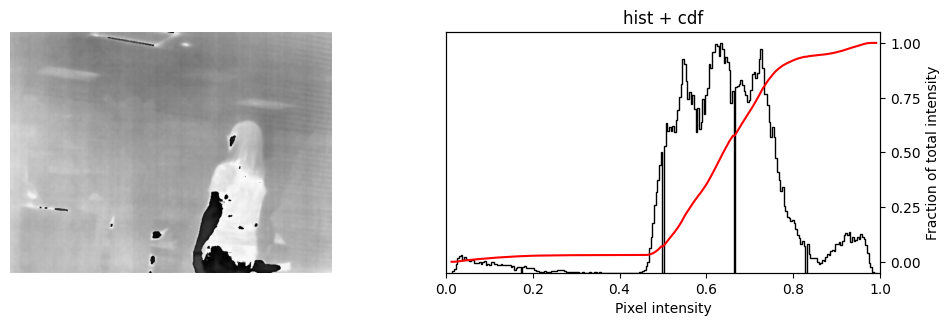

In [37]:
def median_filter(image, kernel_size=5):
    # Apply median filter
    filtered_image = cv2.medianBlur(image.astype(np.uint8), kernel_size)
    return filtered_image

denoise_img = median_filter(corrected_scene_images[350])

hist_cdf_plot(denoise_img)

### 2.3.5 non-local means

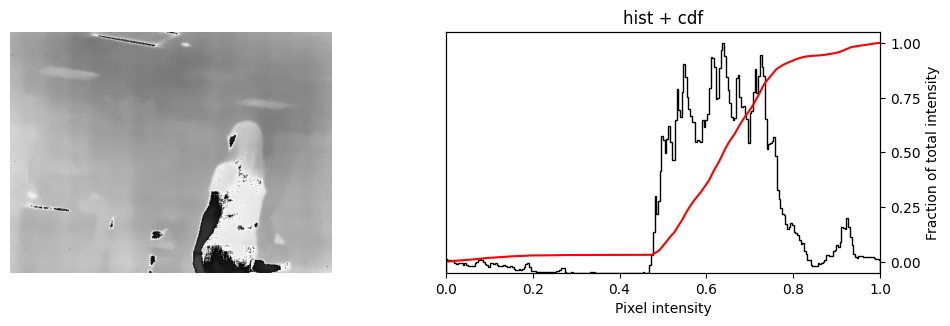

In [38]:
def non_local_means_denoise(image, h=10, templateWindowSize=7, searchWindowSize=21):
    return cv2.fastNlMeansDenoising(np.uint8(image), h=h, templateWindowSize=templateWindowSize, searchWindowSize=searchWindowSize)

denoise_img = non_local_means_denoise(corrected_scene_images[350])

hist_cdf_plot(denoise_img)

### 2.3.6 Combine 

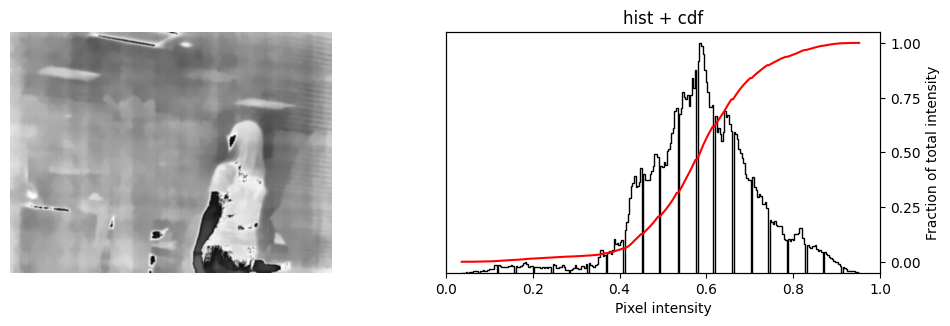

In [43]:
denoise_img = non_local_means_denoise(gaussian_filter(clahe_equalization(corrected_scene_images[350])))
hist_cdf_plot(denoise_img)

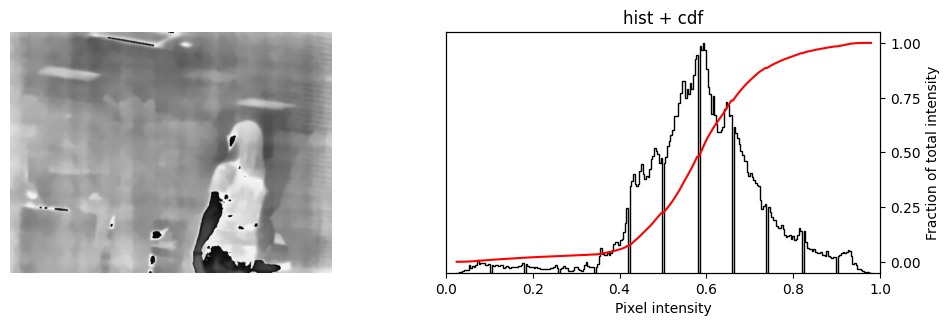

In [51]:
denoise_img = non_local_means_denoise(median_filter(clahe_equalization(corrected_scene_images[350])))
hist_cdf_plot(denoise_img)

## 2.4 Process image as Tensor

In [52]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [53]:
def estimate_parameters(calibration_df):
    calibration_images = calibration_df['image'].values
    calibration_temperatures = np.vstack((calibration_df['t_fpa'].values, calibration_df['t_cn'].values)).T
    
    # Ensure calibration_images is a numeric array
    calibration_images = np.array(calibration_images.tolist(), dtype=np.float32)
    calibration_temperatures = np.array(calibration_temperatures, dtype=np.float32)

    # Convert calibration images and temperatures to PyTorch tensors
    calibration_images_tensor = torch.tensor(calibration_images, dtype=torch.float32).to(device)
    calibration_temperatures_tensor = torch.tensor(calibration_temperatures, dtype=torch.float32).to(device)

    height, width = calibration_images_tensor.shape[1:]
    num_pixels = height * width

    # Reshape images for linear regression
    images_reshaped = calibration_images_tensor.view(calibration_images_tensor.shape[0], -1)
    calibration_temperatures_tensor = calibration_temperatures_tensor.to(device)

    # Add bias term for intercept in linear regression
    X = torch.cat([calibration_temperatures_tensor, torch.ones(calibration_temperatures_tensor.size(0), 1).to(device)], dim=1)

    # Perform linear regression using torch.linalg.lstsq
    responsivities_and_offsets = torch.linalg.lstsq(X, images_reshaped).solution

    # Separate responsivities and offsets
    responsivities = responsivities_and_offsets[:-1, :].T
    offsets = responsivities_and_offsets[-1, :]

    # Reshape back to original image shape
    offsets = offsets.view(height, width).to(device).numpy()
    responsivities = responsivities.view(height, width, -1).to(device).numpy()

    return offsets, responsivities


In [54]:
def apply_correction(scene_image, offsets, responsivities, scene_temp, avg_black_body_temp):
    # Convert inputs to PyTorch tensors
    scene_image_tensor = torch.tensor(scene_image, dtype=torch.float32).to(device)
    offsets_tensor = torch.tensor(offsets, dtype=torch.float32).to(device)
    responsivities_tensor = torch.tensor(responsivities, dtype=torch.float32).to(device)
    scene_temp_tensor = torch.tensor(scene_temp, dtype=torch.float32).to(device)
    avg_black_body_temp_tensor = torch.tensor(avg_black_body_temp, dtype=torch.float32).to(device)

    height, width = scene_image_tensor.shape
    corrected_image_tensor = torch.zeros_like(scene_image_tensor)

    # Calculate expected value
    intercepts_tensor = offsets_tensor
    coef_fpa_tensor = responsivities_tensor[:, :, 0]
    coef_cn_tensor = responsivities_tensor[:, :, 1]
    expected_value = intercepts_tensor + coef_fpa_tensor * scene_temp_tensor + coef_cn_tensor * avg_black_body_temp_tensor
    
    # Apply correction
    corrected_image_tensor = scene_image_tensor - expected_value

    # Convert the result back to a numpy array if needed
    corrected_image = corrected_image_tensor.to(device).numpy()

    return corrected_image

In [55]:
def applier(calibration_df,scene_df):
    offset, gain = estimate_parameters(calibration_df)
    avg_black_body_temp = calibration_df['t_cn'].mean()
    # Process each scene image
    corrected_scene_images = []
    
    for index, row in scene_df.iterrows():
        scene_image = row['image']
        scene_temp = row['t_fpa']
        corrected_image = apply_correction(scene_image, offset, gain, scene_temp, avg_black_body_temp)
        corrected_scene_images.append(corrected_image)

    # Convert corrected_scene_images to numpy array
    return np.array(corrected_scene_images)

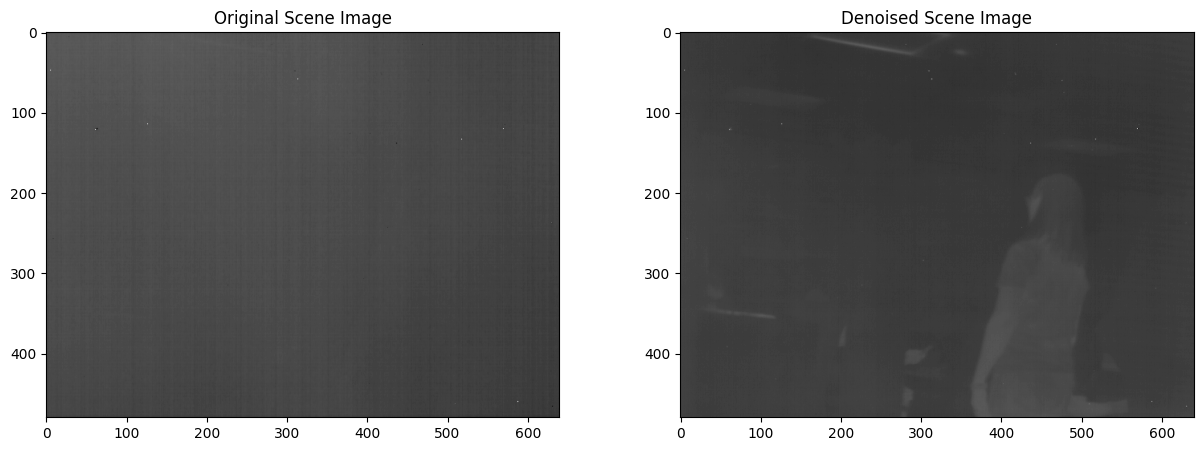

In [56]:
corrected_scene_images = applier(calibration_df,scene_df)
display(scene_df, corrected_scene_images,index=350)

# 2C. Final method

In [57]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [58]:
def estimate_parameters(calibration_df):
    calibration_images = calibration_df['image'].values
    calibration_temperatures = np.vstack((calibration_df['t_fpa'].values, calibration_df['t_cn'].values)).T
    
    # Ensure calibration_images is a numeric array
    calibration_images = np.array(calibration_images.tolist(), dtype=np.float32)
    calibration_temperatures = np.array(calibration_temperatures, dtype=np.float32)

    # Convert calibration images and temperatures to PyTorch tensors
    calibration_images_tensor = torch.tensor(calibration_images, dtype=torch.float32).to(device)
    calibration_temperatures_tensor = torch.tensor(calibration_temperatures, dtype=torch.float32).to(device)

    height, width = calibration_images_tensor.shape[1:]
    num_pixels = height * width

    # Reshape images for linear regression
    images_reshaped = calibration_images_tensor.view(calibration_images_tensor.shape[0], -1)
    calibration_temperatures_tensor = calibration_temperatures_tensor.to(device)

    # Add bias term for intercept in linear regression
    X = torch.cat([calibration_temperatures_tensor, torch.ones(calibration_temperatures_tensor.size(0), 1).to(device)], dim=1)

    # Perform linear regression using torch.linalg.lstsq
    responsivities_and_offsets = torch.linalg.lstsq(X, images_reshaped).solution

    # Separate responsivities and offsets
    responsivities = responsivities_and_offsets[:-1, :].T
    offsets = responsivities_and_offsets[-1, :]

    # Reshape back to original image shape
    offsets = offsets.view(height, width).to(device).numpy()
    responsivities = responsivities.view(height, width, -1).to(device).numpy()

    return offsets, responsivities


In [59]:
def apply_correction(scene_image, offsets, responsivities, scene_temp, avg_black_body_temp):
    # Convert inputs to PyTorch tensors
    scene_image_tensor = torch.tensor(scene_image, dtype=torch.float32).to(device)
    offsets_tensor = torch.tensor(offsets, dtype=torch.float32).to(device)
    responsivities_tensor = torch.tensor(responsivities, dtype=torch.float32).to(device)
    scene_temp_tensor = torch.tensor(scene_temp, dtype=torch.float32).to(device)
    avg_black_body_temp_tensor = torch.tensor(avg_black_body_temp, dtype=torch.float32).to(device)

    height, width = scene_image_tensor.shape
    corrected_image_tensor = torch.zeros_like(scene_image_tensor)

    # Calculate expected value
    intercepts_tensor = offsets_tensor
    coef_fpa_tensor = responsivities_tensor[:, :, 0]
    coef_cn_tensor = responsivities_tensor[:, :, 1]
    expected_value = intercepts_tensor + coef_fpa_tensor * scene_temp_tensor + coef_cn_tensor * avg_black_body_temp_tensor
    
    # Apply correction
    corrected_image_tensor = scene_image_tensor - expected_value

    # Convert the result back to a numpy array if needed
    corrected_image = corrected_image_tensor.to(device).numpy()

    return corrected_image

In [60]:
def applier(calibration_df,scene_df):
    offset, gain = estimate_parameters(calibration_df)
    avg_black_body_temp = calibration_df['t_cn'].mean()
    # Process each scene image
    corrected_scene_images = []
    
    for index, row in scene_df.iterrows():
        scene_image = row['image']
        scene_temp = row['t_fpa']
        corrected_image = apply_correction(scene_image, offset, gain, scene_temp, avg_black_body_temp)
        corrected_scene_images.append(corrected_image)

    # Convert corrected_scene_images to numpy array
    return np.array(corrected_scene_images)

In [61]:
def gaussian_filter(image, kernel_size=5, sigma=1.0):
    # Apply Gaussian filter
    filtered_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    return filtered_image

denoise_img = gaussian_filter(corrected_scene_images[350])

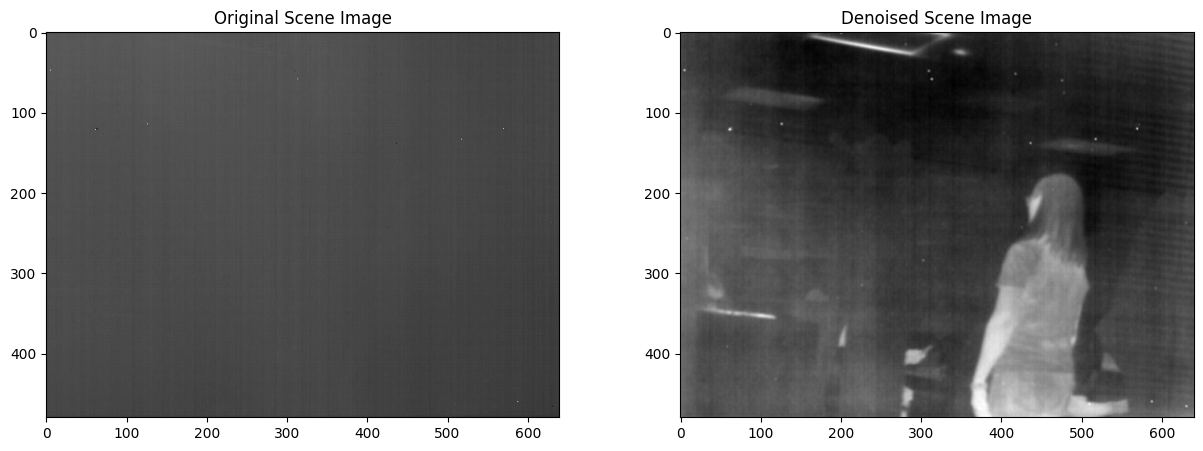

In [62]:
corrected_scene_images = applier(calibration_df,scene_df)
denoise_scene_images = [gaussian_filter(image) for image in corrected_scene_images]
display(scene_df, denoise_scene_images,index=350)

# 2D. Conclusion